In [1]:
!pip install tensorflow==2.15
!pip install qutip==4.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import os
import sys
import csv
import math
import time
import re
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
#from keras.layers.preprocessing import preprocessing_utils

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#!pip install qutip
import qutip as qt
qt.__version__

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


'4.7.6'

In [6]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/sdes')
import sde_solve
import sde_systems
import data_gen

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/systems')
import rabi_weak_meas

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models')
import fusion
import flex

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models/test')
import test_fusion

In [7]:
import imp
imp.reload(fusion)
imp.reload(flex)
imp.reload(sde_systems)
imp.reload(data_gen)
imp.reload(sde_solve)
imp.reload(test_fusion)

<module 'test_fusion' from '/content/gdrive/MyDrive/git/quantumML/python/models/test/test_fusion.py'>

# XYZ Data

In [8]:
mint = 0
maxt = 4.0
deltat = 2**(-6)
tvec = np.arange(mint,maxt,deltat)

stride = 64

epsilons = np.arange(0.0, 2.0, 0.05)
all_params = epsilons[:,tf.newaxis]
input_params=[4]

omega = 1.395
kappa = 0.83156
eta = 0.1469
gamma_s = 0.1
eps = 0.1
params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

In [9]:
# Load large dataset averaged over 10 runs
mint = 0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)
voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/new_data/xyz_zz00_gammas0p1/new_data_ZZ00_kappa0_eta0_gammas0p1_grp100_N40_T4_dt2em8_xyz_avg100/voltage'

voltage = tf.saved_model.load(voltage_dir)
#epsilons = tf.cast(tf.saved_model.load(epsilons_dir), dtype=all_probs.dtype)
epsilons = np.arange(0.0, 2.0, 0.05)

voltage = voltage[...,0,:]
print(voltage.shape)

(40, 100, 1024, 2, 3)


In [10]:
voltage_orig = voltage

In [11]:
# Subsample in time
stride = 4
voltage = voltage[:,:,::stride,...]
#all_probs = all_probs[:,::stride,:]

mint = 0
maxt = 4.0
deltat = 2**(-8)*stride
tvec = np.arange(mint,maxt,deltat)

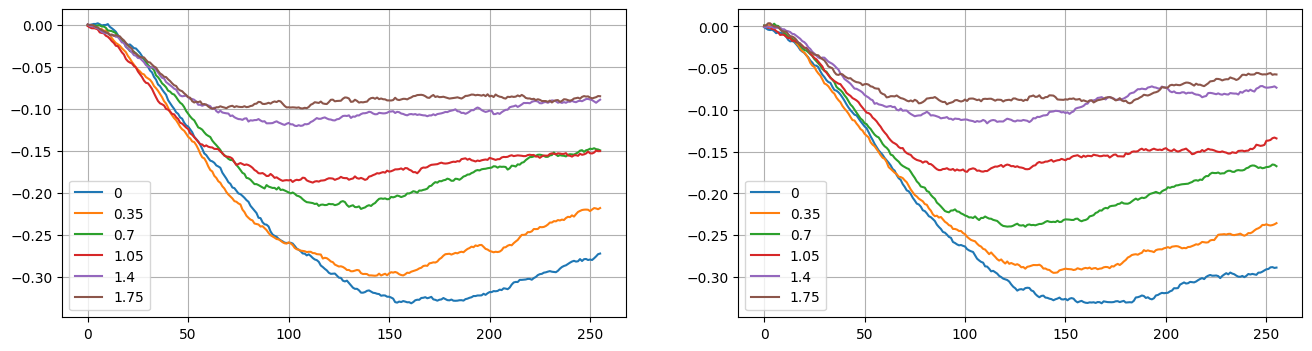

In [12]:
# Plot the data averages
meas_idx = 1
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  for param_idx in range(0,40,7):
    plt.plot(tf.reduce_mean(voltage[param_idx,:,:,qidx,meas_idx], axis=0), label=f'{epsilons[param_idx]:.3g}')
    for grp_idx in range(0):
      plt.plot(voltage[param_idx,grp_idx,:,qidx,meas_idx])
  plt.legend()
  plt.grid();

In [13]:
# Compute the voltage centered differences
#voltage_diff = (voltage[:,:,2:,...] - voltage[:,:,:-2,...])/(2.0*deltat)
voltage_diff = (voltage[:,:,1:,...] - voltage[:,:,:-1,...])/(deltat)
tvec_diff = tvec[1:-1]

In [14]:
epsidx = 21
eps = epsilons[epsidx]
sx0 = qt.tensor(qt.sigmax(), qt.identity(2))
sx1 = qt.tensor(qt.identity(2), qt.sigmax())
sy0 = qt.tensor(qt.sigmay(), qt.identity(2))
sy1 = qt.tensor(qt.identity(2), qt.sigmay())
sz0 = qt.tensor(qt.sigmaz(), qt.identity(2))
sz1 = qt.tensor(qt.identity(2), qt.sigmaz())
sm0 = qt.tensor(qt.sigmam(), qt.identity(2))
sm1 = qt.tensor(qt.identity(2), qt.sigmam())

sxx = qt.tensor(qt.sigmax(), qt.sigmax())
sxy = qt.tensor(qt.sigmax(), qt.sigmay())
sxz = qt.tensor(qt.sigmax(), qt.sigmaz())

syx = qt.tensor(qt.sigmay(), qt.sigmax())
syy = qt.tensor(qt.sigmay(), qt.sigmay())
syz = qt.tensor(qt.sigmay(), qt.sigmaz())

szx = qt.tensor(qt.sigmaz(), qt.sigmax())
szy = qt.tensor(qt.sigmaz(), qt.sigmay())
szz = qt.tensor(qt.sigmaz(), qt.sigmaz())

H = 0.5*omega*(sx0 + sx1) + eps*szz

psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0))
qtrho0 = psi0*psi0.dag()

In [15]:
ntraj = 10000
result = qt.smesolve(H, qtrho0, tvec, c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sz0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sz1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1], sc_ops=[np.sqrt(0.5*eta*kappa) * sz0, np.sqrt(0.5*eta*kappa) * sz1], e_ops=[sz0,sz1], ntraj=ntraj, store_measurement=True)

10.0%. Run time:   4.05s. Est. time left: 00:00:00:36
20.0%. Run time:   8.14s. Est. time left: 00:00:00:32
30.0%. Run time:  12.22s. Est. time left: 00:00:00:28
40.0%. Run time:  16.54s. Est. time left: 00:00:00:24
50.0%. Run time:  20.75s. Est. time left: 00:00:00:20
60.0%. Run time:  24.83s. Est. time left: 00:00:00:16
70.0%. Run time:  28.93s. Est. time left: 00:00:00:12
80.0%. Run time:  33.07s. Est. time left: 00:00:00:08
90.0%. Run time:  37.15s. Est. time left: 00:00:00:04
Total run time:  41.24s


In [16]:
all_meas = np.zeros([len(result.measurement), result.measurement[0].shape[0], result.measurement[0].shape[1]], result.measurement[0].dtype)
for idx in range(len(result.measurement)):
  all_meas[idx,:,:] = result.measurement[idx]
all_meas.shape

(10000, 256, 2)

In [17]:
print(tf.math.reduce_std(tf.reduce_mean(all_meas[100:200,:,0], axis=0)))
tf.math.reduce_std(voltage_diff[epsidx,2,:,0,2])

tf.Tensor(0.8215533423120517, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=0.826578672611123>

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


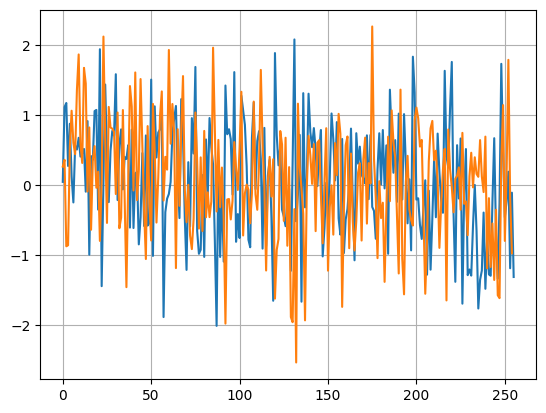

In [18]:
plt.plot(tf.reduce_mean(all_meas[100:200,:,0], axis=0))
plt.plot(voltage_diff[epsidx,2,:,0,2])
#plt.plot(tf.math.reduce_std(all_meas[:,:,0], axis=0))
#plt.plot(all_meas[0,:,0])
#plt.plot(result.expect[0])
#plt.plot(all_exp[:,4])
plt.grid()

In [19]:
all_meas.shape

(10000, 256, 2)

In [20]:
qutip_diff = tf.reshape(all_meas, [-1,100,all_meas.shape[1], all_meas.shape[2]])
qutip_diff = tf.reduce_mean(qutip_diff, axis=1)
qutip_diff.shape

TensorShape([100, 256, 2])

In [21]:
def diff_to_volt(diff, deltat):
  volt = np.zeros_like(diff.numpy())
  for tidx in range(diff.shape[-2]):
    if tidx < diff.shape[-2] - 1:
      volt[...,tidx+1,:] = volt[...,tidx,:] + deltat*diff[...,tidx,:]
    else:
      volt = np.concatenate([volt, volt[...,tidx:tidx+1,:] + deltat*diff[...,tidx:tidx+1,:]], axis=-2)
  return volt

In [22]:
volt = diff_to_volt(voltage_diff[...,2], deltat)
qutip_volt = diff_to_volt(qutip_diff, deltat)[:,:-1,:]

In [23]:
print(volt.shape)
print(qutip_volt.shape)

(40, 100, 256, 2)
(100, 256, 2)


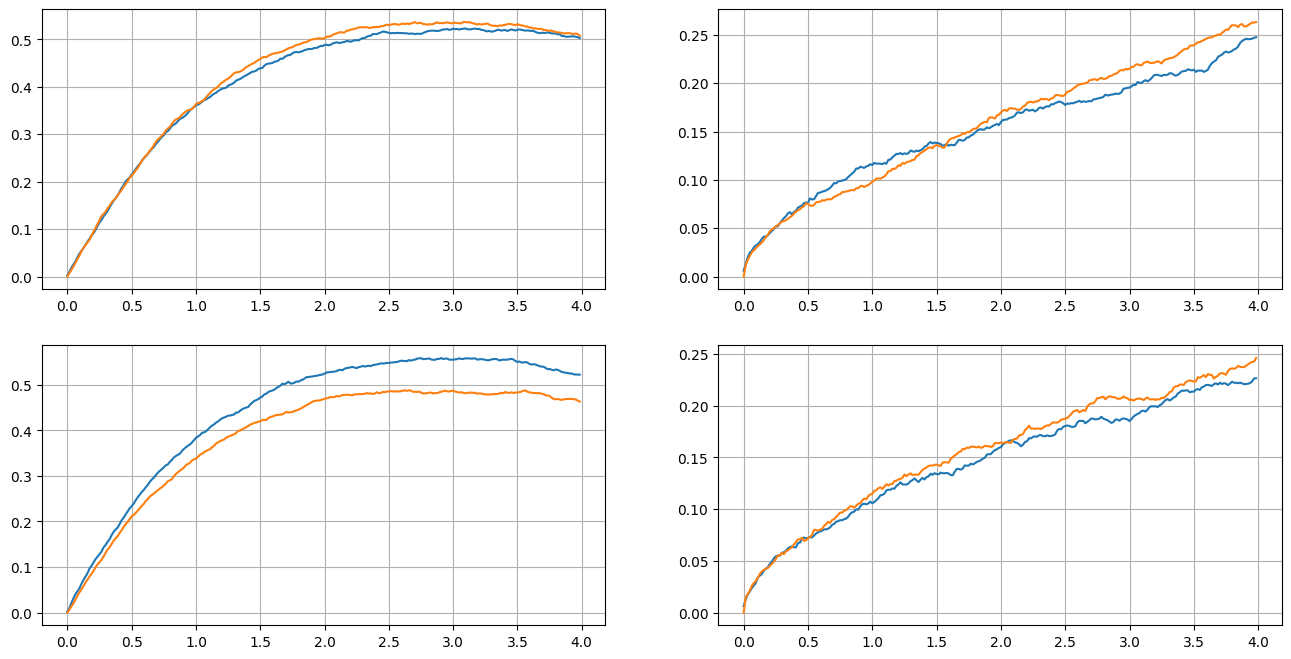

In [24]:
plt.figure(figsize=(16,8))

for qidx in range(2):
  # Plot means
  plt.subplot(2,2,qidx*2 + 1)
  plt.plot(tvec, tf.reduce_mean(voltage[epsidx,:,:,qidx,2], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

  # Plot std devs
  plt.subplot(2,2,qidx*2 + 2)
  plt.plot(tvec, tf.math.reduce_std(voltage[epsidx,:,:,qidx,2], axis=0))
  plt.plot(tvec, tf.math.reduce_std(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

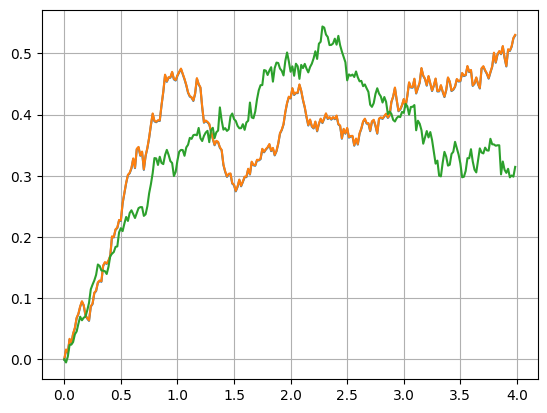

In [25]:
plt.plot(tvec, voltage[epsidx,0,:,0,2])
plt.plot(tvec, volt[epsidx,0,:,0])
plt.plot(tvec, qutip_volt[0,:,0])
plt.grid()

## Check X measurement

In [26]:
meas_idx = 0
m0 = sx0
m1 = sx1

In [27]:
ntraj = 10000
result = qt.smesolve(H, qtrho0, tvec,
                     c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * m0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * m1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1],
                     sc_ops=[np.sqrt(0.5*eta*kappa) * m0, np.sqrt(0.5*eta*kappa) * m1],
                     e_ops=[m0, m1],
                     solver='euler-maruyama', ntraj=ntraj, store_measurement=True)

10.0%. Run time:   2.01s. Est. time left: 00:00:00:18
20.0%. Run time:   3.96s. Est. time left: 00:00:00:15
30.0%. Run time:   5.91s. Est. time left: 00:00:00:13
40.0%. Run time:   7.87s. Est. time left: 00:00:00:11
50.0%. Run time:   9.83s. Est. time left: 00:00:00:09
60.0%. Run time:  11.83s. Est. time left: 00:00:00:07
70.0%. Run time:  13.80s. Est. time left: 00:00:00:05
80.0%. Run time:  15.77s. Est. time left: 00:00:00:03
90.0%. Run time:  17.72s. Est. time left: 00:00:00:01
Total run time:  19.67s


In [28]:
all_meas = np.zeros([len(result.measurement), result.measurement[0].shape[0], result.measurement[0].shape[1]], result.measurement[0].dtype)
for idx in range(len(result.measurement)):
  all_meas[idx,:,:] = result.measurement[idx]
all_meas.shape

(10000, 256, 2)

In [29]:
print(tf.math.reduce_std(tf.reduce_mean(all_meas[100:200,:,0], axis=0)))
tf.math.reduce_std(voltage_diff[epsidx,2,:,0,meas_idx])

tf.Tensor(0.8422923149943071, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=0.8077128207274892>

In [30]:
qutip_diff = tf.reshape(all_meas, [-1,100,all_meas.shape[1], all_meas.shape[2]])
qutip_diff = tf.reduce_mean(qutip_diff, axis=1)
qutip_diff.shape

TensorShape([100, 256, 2])

In [31]:
volt = diff_to_volt(voltage_diff[...,meas_idx], deltat)
qutip_volt = diff_to_volt(qutip_diff, deltat)[:,:-1,:]

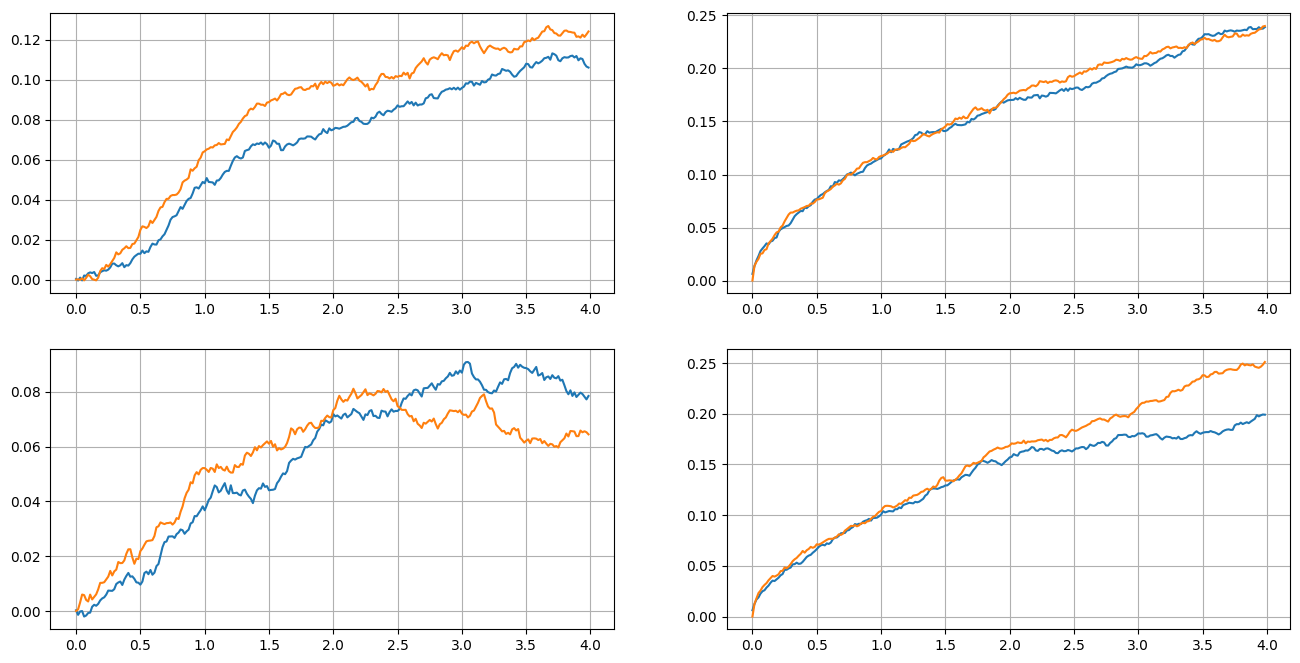

In [32]:
plt.figure(figsize=(16,8))

for qidx in range(2):
  # Plot means
  plt.subplot(2,2,qidx*2 + 1)
  plt.plot(tvec, tf.reduce_mean(voltage[epsidx,:,:,qidx,meas_idx], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

  # Plot std devs
  plt.subplot(2,2,qidx*2 + 2)
  plt.plot(tvec, tf.math.reduce_std(voltage[epsidx,:,:,qidx,meas_idx], axis=0))
  plt.plot(tvec, tf.math.reduce_std(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

## Check Y measurement

In [33]:
meas_idx = 1
m0 = sy0
m1 = sy1

In [34]:
ntraj = 10000
result = qt.smesolve(H, qtrho0, tvec,
                     c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * m0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * m1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1],
                     sc_ops=[np.sqrt(0.5*eta*kappa) * m0, np.sqrt(0.5*eta*kappa) * m1],
                     e_ops=[m0, m1],
                     solver='euler-maruyama', ntraj=ntraj, store_measurement=True)

10.0%. Run time:   1.97s. Est. time left: 00:00:00:17
20.0%. Run time:   3.95s. Est. time left: 00:00:00:15
30.0%. Run time:   5.92s. Est. time left: 00:00:00:13
40.0%. Run time:   7.87s. Est. time left: 00:00:00:11
50.0%. Run time:   9.82s. Est. time left: 00:00:00:09
60.0%. Run time:  11.78s. Est. time left: 00:00:00:07
70.0%. Run time:  13.74s. Est. time left: 00:00:00:05
80.0%. Run time:  15.72s. Est. time left: 00:00:00:03
90.0%. Run time:  17.67s. Est. time left: 00:00:00:01
Total run time:  19.63s


In [35]:
all_meas = np.zeros([len(result.measurement), result.measurement[0].shape[0], result.measurement[0].shape[1]], result.measurement[0].dtype)
for idx in range(len(result.measurement)):
  all_meas[idx,:,:] = result.measurement[idx]
all_meas.shape

(10000, 256, 2)

In [36]:
print(tf.math.reduce_std(tf.reduce_mean(all_meas[100:200,:,0], axis=0)))
tf.math.reduce_std(voltage_diff[epsidx,2,:,0,meas_idx])

tf.Tensor(0.8328286315911724, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=0.8366983972822348>

In [37]:
qutip_diff = tf.reshape(all_meas, [-1,100,all_meas.shape[1], all_meas.shape[2]])
qutip_diff = tf.reduce_mean(qutip_diff, axis=1)
qutip_diff.shape

TensorShape([100, 256, 2])

In [38]:
volt = diff_to_volt(voltage_diff[...,meas_idx], deltat)
qutip_volt = diff_to_volt(qutip_diff, deltat)[:,:-1,:]

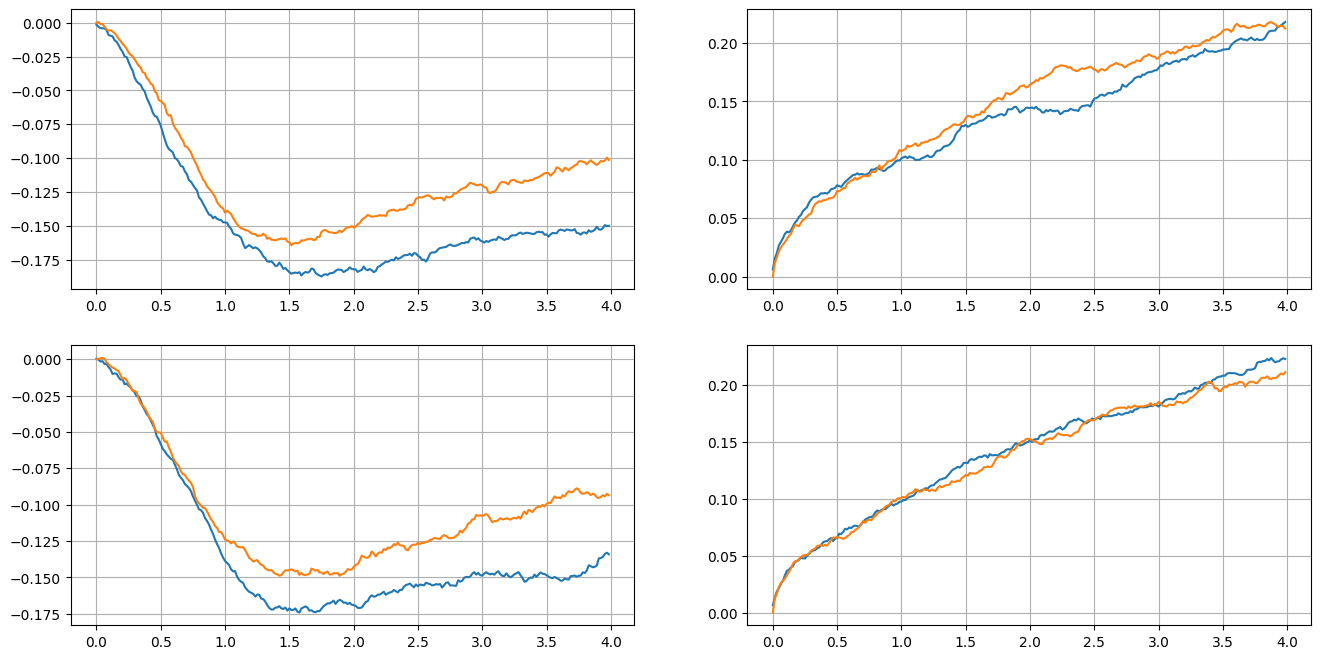

In [39]:
plt.figure(figsize=(16,8))

for qidx in range(2):
  # Plot means
  plt.subplot(2,2,qidx*2 + 1)
  plt.plot(tvec, tf.reduce_mean(voltage[epsidx,:,:,qidx,meas_idx], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

  # Plot std devs
  plt.subplot(2,2,qidx*2 + 2)
  plt.plot(tvec, tf.math.reduce_std(voltage[epsidx,:,:,qidx,meas_idx], axis=0))
  plt.plot(tvec, tf.math.reduce_std(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

# XY Data

In [40]:
mint = 0
maxt = 4.0
deltat = 2**(-6)
tvec = np.arange(mint,maxt,deltat)

stride = 64

epsilons = np.arange(0.0, 2.0, 0.05)
all_params = epsilons[:,tf.newaxis]
input_params=[4]

omega = 1.395
kappa = 4.0*0.83156
eta = 0.1469
gamma_s = 0.0
eps = 0.1
params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

In [41]:
# Load large dataset averaged over 10 runs
mint = 0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)
voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/new_data/xy_xy00_kappa0x4/new_data_XY00_kappa0x4_eta0_grp100_N40_T4_dt2em8_xy_avg100_32K/voltage'
#voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xy_xy00_kappa0x4/large_eps_XY00_kappa0x4_eta0_grp100_N40_T4_dt2em8_xy_avg200/voltage'
#voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xx_xx00_kappa0x4/large_eps_XX00_kappa0x4_eta0_grp1000_N40_T4_dt2em8_xx_avg1000/voltage'
#voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xyz_xy00/large_eps_ZZ00_kappa0_eta0_grp100_N40_T4_dt2em8_multimeas_avg200/voltage'
#epsilons_dir = '/content/gdrive/MyDrive/Research/QML/models/xyz_zz00/large_eps_ZZ00_kappa0_eta0_grp100_N40_T4_dt2em8_multimeas_avg100/epsilons'

voltage = tf.saved_model.load(voltage_dir)
#epsilons = tf.cast(tf.saved_model.load(epsilons_dir), dtype=all_probs.dtype)
epsilons = np.arange(0.0, 2.0, 0.05)

voltage = voltage[...,0,:]
print(voltage.shape)

(40, 320, 1024, 2, 1)


In [42]:
# Subsample in time
stride = 4
voltage = voltage[:,:,::stride,...]
#all_probs = all_probs[:,::stride,:]

mint = 0
maxt = 4.0
deltat = 2**(-8)*stride
tvec = np.arange(mint,maxt,deltat)

In [43]:
voltage_orig = voltage
voltage.shape

TensorShape([40, 320, 256, 2, 1])

In [44]:
# Compute the voltage centered differences
#voltage_diff = (voltage[:,:,2:,...] - voltage[:,:,:-2,...])/(2.0*deltat)
voltage_diff = (voltage[:,:,1:,...] - voltage[:,:,:-1,...])/(deltat)
tvec_diff = tvec[1:-1]

In [45]:
voltage_diff.shape

TensorShape([40, 320, 255, 2, 1])

In [46]:
epsidx = 30
eps = epsilons[epsidx]
sx0 = qt.tensor(qt.sigmax(), qt.identity(2))
sx1 = qt.tensor(qt.identity(2), qt.sigmax())
sy0 = qt.tensor(qt.sigmay(), qt.identity(2))
sy1 = qt.tensor(qt.identity(2), qt.sigmay())
sz0 = qt.tensor(qt.sigmaz(), qt.identity(2))
sz1 = qt.tensor(qt.identity(2), qt.sigmaz())
sm0 = qt.tensor(qt.sigmam(), qt.identity(2))
sm1 = qt.tensor(qt.identity(2), qt.sigmam())

sxx = qt.tensor(qt.sigmax(), qt.sigmax())
sxy = qt.tensor(qt.sigmax(), qt.sigmay())
sxz = qt.tensor(qt.sigmax(), qt.sigmaz())

syx = qt.tensor(qt.sigmay(), qt.sigmax())
syy = qt.tensor(qt.sigmay(), qt.sigmay())
syz = qt.tensor(qt.sigmay(), qt.sigmaz())

szx = qt.tensor(qt.sigmaz(), qt.sigmax())
szy = qt.tensor(qt.sigmaz(), qt.sigmay())
szz = qt.tensor(qt.sigmaz(), qt.sigmaz())

H = 0.5*omega*(sx0 + sx1) + eps*szz

xup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + qt.basis(2,1))
yup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + 1j*qt.basis(2,1))
psi0 = qt.tensor(xup, yup)
qtrho0 = psi0*psi0.dag()

In [47]:
ntraj = 32000
result = qt.smesolve(H, qtrho0, tvec,
                     #c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sx0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sy1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1],
                     c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sx0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sy1],
                     sc_ops=[np.sqrt(0.5*eta*kappa) * sx0, np.sqrt(0.5*eta*kappa) * sy1],
                     e_ops=[sx0,sy0,sz0],
                     ntraj=ntraj,
                     dW_factors=[1,1],
                     solver='euler-maruyama',
                     store_measurement=True)

10.0%. Run time:   9.41s. Est. time left: 00:00:01:24
20.0%. Run time:  16.26s. Est. time left: 00:00:01:05
30.0%. Run time:  23.40s. Est. time left: 00:00:00:54
40.0%. Run time:  30.32s. Est. time left: 00:00:00:45
50.0%. Run time:  37.35s. Est. time left: 00:00:00:37
60.0%. Run time:  44.16s. Est. time left: 00:00:00:29
70.0%. Run time:  50.92s. Est. time left: 00:00:00:21
80.0%. Run time:  57.73s. Est. time left: 00:00:00:14
90.0%. Run time:  64.57s. Est. time left: 00:00:00:07
Total run time:  71.34s


In [48]:
all_meas = np.zeros([len(result.measurement), result.measurement[0].shape[0], result.measurement[0].shape[1]], result.measurement[0].dtype)
for idx in range(len(result.measurement)):
  all_meas[idx,:,:] = result.measurement[idx]
all_meas.shape

(32000, 256, 2)

In [49]:
print(tf.math.reduce_std(tf.reduce_mean(all_meas[200:300,:,0], axis=0)))
tf.math.reduce_std(voltage_diff[epsidx,4,:,0,0])

tf.Tensor(0.8546824820508714, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=0.8414795018490837>

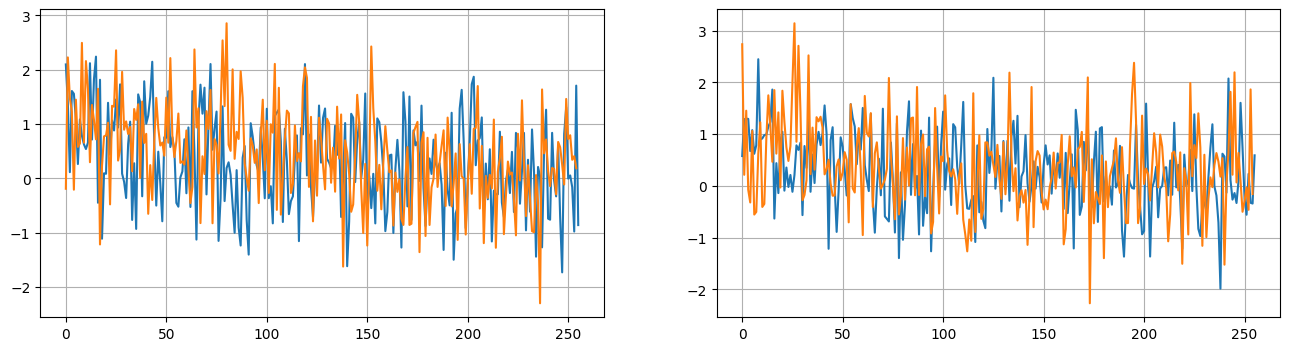

In [50]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tf.reduce_mean(all_meas[200:300,:,qidx], axis=0))
  plt.plot(voltage_diff[epsidx,1,:,qidx,0])
  #plt.plot(tf.math.reduce_std(all_meas[:,:,0], axis=0))
  #plt.plot(all_meas[0,:,0])
  #plt.plot(result.expect[0])
  #plt.plot(all_exp[:,4])
  plt.grid()

In [51]:
all_meas.shape

(32000, 256, 2)

In [52]:
qutip_diff = tf.reshape(all_meas, [-1,100,all_meas.shape[1], all_meas.shape[2]])
qutip_diff = tf.reduce_mean(qutip_diff, axis=1)
qutip_diff.shape

TensorShape([320, 256, 2])

In [53]:
#for ii in range(35):
#  print(tf.math.reduce_std(qutip_diff[ii,:,0]).numpy(), tf.math.reduce_std(voltage_diff[epsidx,ii,:,0,0]).numpy())
print(tf.reduce_mean(tf.math.reduce_std(qutip_diff[:,:,0], axis=1)).numpy(), tf.reduce_mean(tf.math.reduce_std(voltage_diff[epsidx,:,:,0,0], axis=1)).numpy())
print(tf.reduce_mean(tf.math.reduce_std(qutip_diff[:,:,1], axis=1)).numpy(), tf.reduce_mean(tf.math.reduce_std(voltage_diff[epsidx,:,:,1,0], axis=1)).numpy())

0.8477597091811795 0.8421963699934917
0.849538347303201 0.84353749958296


In [54]:
def diff_to_volt(diff, deltat):
  volt = np.zeros_like(diff.numpy())
  for tidx in range(diff.shape[-2]):
    if tidx < diff.shape[-2] - 1:
      volt[...,tidx+1,:] = volt[...,tidx,:] + deltat*diff[...,tidx,:]
    else:
      volt = np.concatenate([volt, volt[...,tidx:tidx+1,:] + deltat*diff[...,tidx:tidx+1,:]], axis=-2)
  return volt

In [55]:
volt = diff_to_volt(voltage_diff[...,0], deltat)
qutip_volt = diff_to_volt(qutip_diff, deltat)[:,:-1,:]

In [56]:
print(volt.shape)
print(qutip_volt.shape)

(40, 320, 256, 2)
(320, 256, 2)


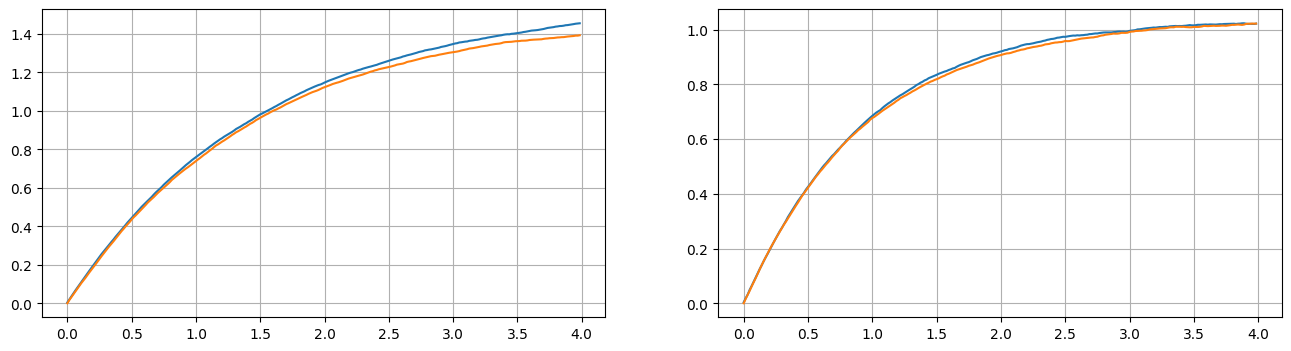

In [57]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tvec, tf.reduce_mean(voltage[epsidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

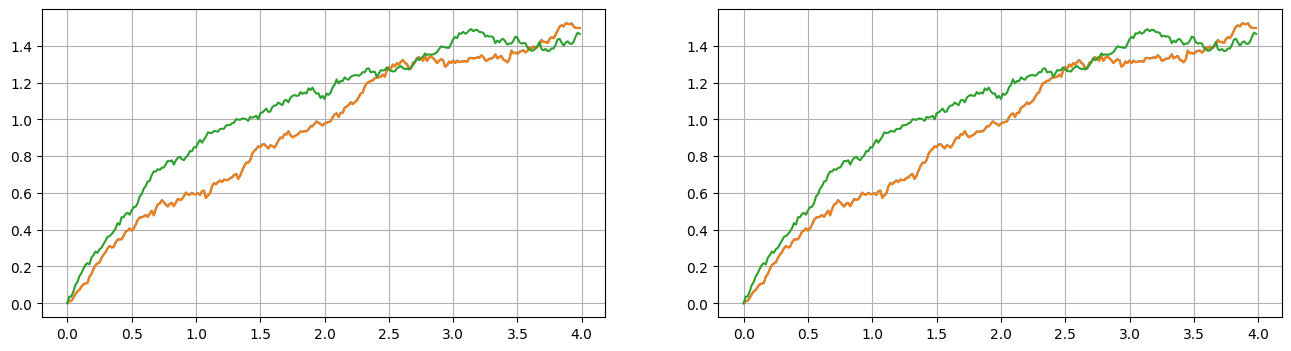

In [58]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tvec, voltage[epsidx,0,:,0,0])
  plt.plot(tvec, volt[epsidx,0,:,0])
  plt.plot(tvec, qutip_volt[0,:,0])
  plt.grid()

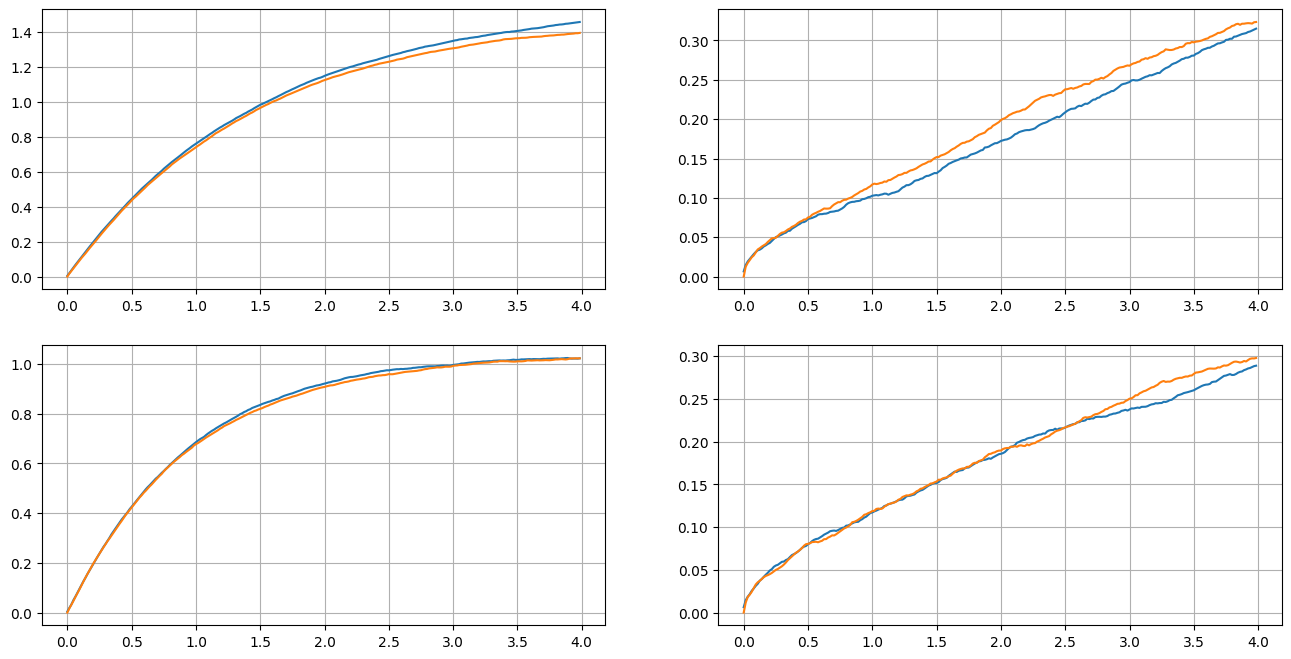

In [59]:
plt.figure(figsize=(16,8))

for qidx in range(2):
  # Plot means
  plt.subplot(2,2,qidx*2 + 1)
  plt.plot(tvec, tf.reduce_mean(voltage[epsidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

  # Plot std devs
  plt.subplot(2,2,qidx*2 + 2)
  plt.plot(tvec, tf.math.reduce_std(voltage[epsidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.math.reduce_std(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

In [60]:
qutip_volt.shape

(320, 256, 2)

In [61]:
num_to_avg = 1
for ii in range(1,101):
  print('Reading file', ii)
  voltage_dir = f'/content/gdrive/MyDrive/Research/QML/models/new_data/xy_xy00_kappa0x4/new_data_XY00_kappa0x4_eta0_grp100_N40_T4_dt2em8_xy_{ii}/voltage'
  voltage2 = tf.saved_model.load(voltage_dir)[...,0,:]

  if ii == 1:
    voltage_all = voltage2
  else:
    voltage_all = tf.concat([voltage_all, voltage2], axis=1)

  print(voltage_all.shape)

Reading file 1
(40, 100, 1024, 2, 1)
Reading file 2
(40, 200, 1024, 2, 1)
Reading file 3
(40, 300, 1024, 2, 1)
Reading file 4
(40, 400, 1024, 2, 1)
Reading file 5
(40, 500, 1024, 2, 1)
Reading file 6
(40, 600, 1024, 2, 1)
Reading file 7
(40, 700, 1024, 2, 1)
Reading file 8
(40, 800, 1024, 2, 1)
Reading file 9
(40, 900, 1024, 2, 1)
Reading file 10
(40, 1000, 1024, 2, 1)
Reading file 11
(40, 1100, 1024, 2, 1)
Reading file 12
(40, 1200, 1024, 2, 1)
Reading file 13
(40, 1300, 1024, 2, 1)
Reading file 14
(40, 1400, 1024, 2, 1)
Reading file 15
(40, 1500, 1024, 2, 1)
Reading file 16
(40, 1600, 1024, 2, 1)
Reading file 17
(40, 1700, 1024, 2, 1)
Reading file 18
(40, 1800, 1024, 2, 1)
Reading file 19
(40, 1900, 1024, 2, 1)
Reading file 20
(40, 2000, 1024, 2, 1)
Reading file 21
(40, 2100, 1024, 2, 1)
Reading file 22
(40, 2200, 1024, 2, 1)
Reading file 23
(40, 2300, 1024, 2, 1)
Reading file 24
(40, 2400, 1024, 2, 1)
Reading file 25
(40, 2500, 1024, 2, 1)
Reading file 26
(40, 2600, 1024, 2, 1)
Read

In [62]:
voltage_all = voltage_all[:,:,::stride,...]

In [63]:
qutip_diff = tf.reshape(all_meas, [-1,1,all_meas.shape[1], all_meas.shape[2]])
qutip_diff = tf.reduce_mean(qutip_diff, axis=1)
qutip_diff.shape

TensorShape([32000, 256, 2])

In [64]:
qutip_volt = diff_to_volt(qutip_diff, deltat)[:,:-1,:]

In [65]:
print(qutip_volt.shape)

(32000, 256, 2)


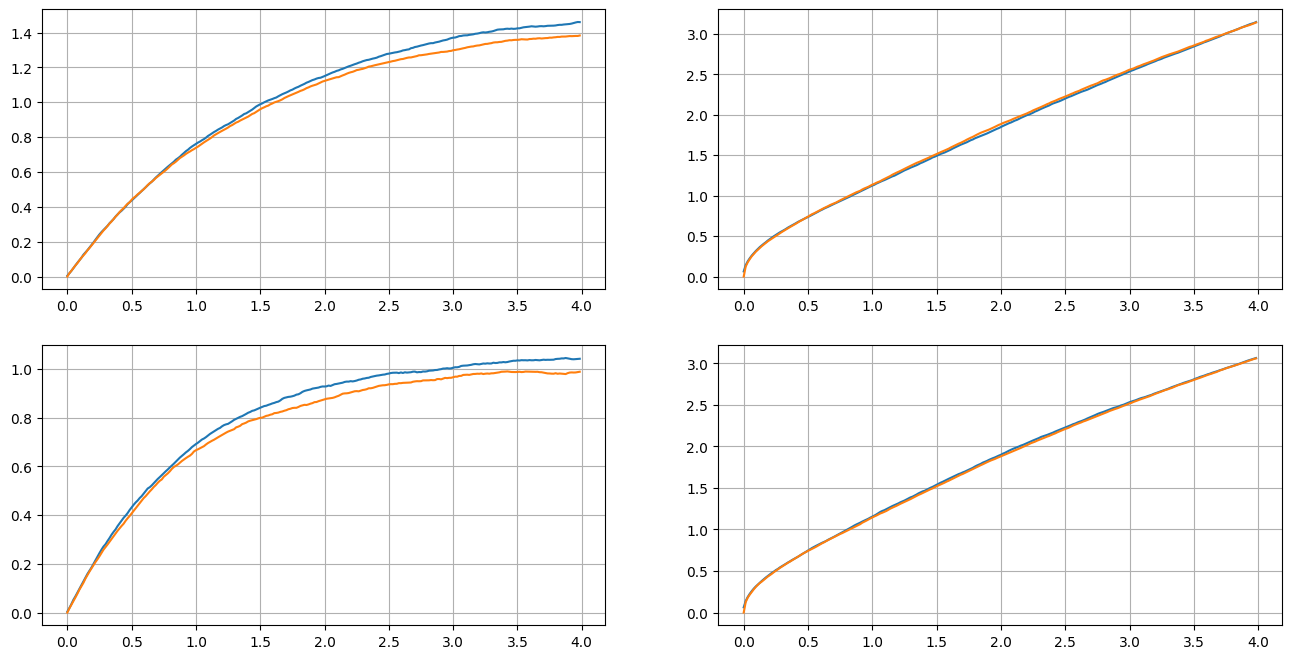

In [66]:
plt.figure(figsize=(16,8))

for qidx in range(2):
  # Plot means
  plt.subplot(2,2,qidx*2 + 1)
  plt.plot(tvec, tf.reduce_mean(voltage_all[epsidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:10000,:,qidx], axis=0))
  plt.grid()

  # Plot std devs
  plt.subplot(2,2,qidx*2 + 2)
  plt.plot(tvec, tf.math.reduce_std(voltage_all[epsidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.math.reduce_std(qutip_volt[:10000,:,qidx], axis=0))
  plt.grid()

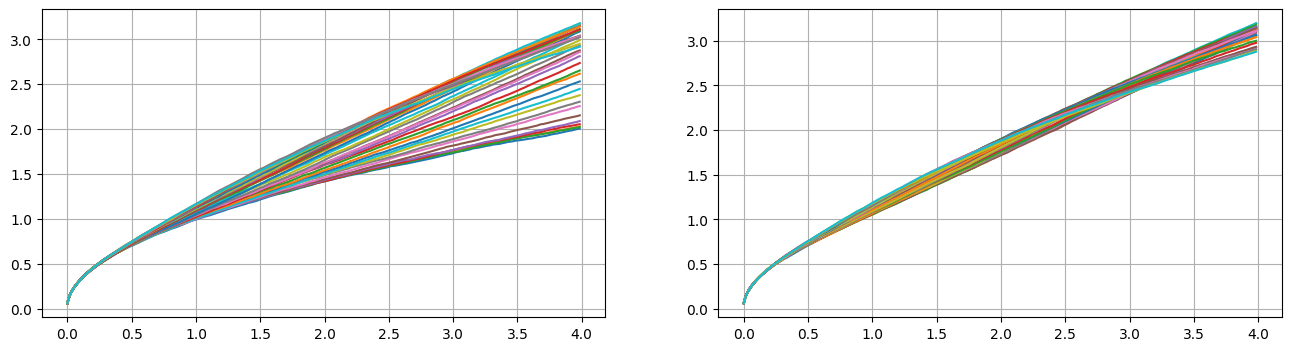

In [67]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  for idx in range(0,40,1):
    plt.plot(tvec, tf.math.reduce_std(voltage_all[idx,:,:,qidx,0], axis=0))
  plt.grid();

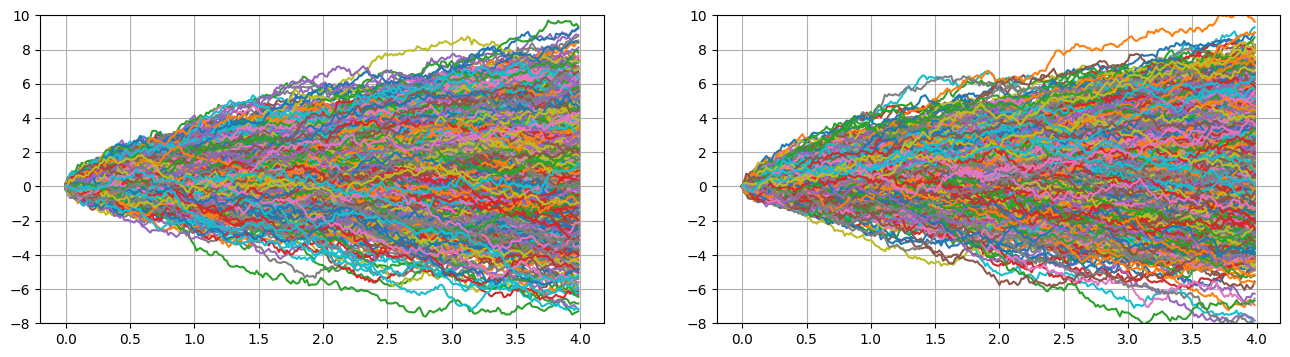

In [68]:
qidx = 0
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
for idx in range(2,10000,10):
  plt.plot(tvec, voltage_all[epsidx,idx,:,qidx,0])
  plt.ylim([-8,10])
plt.grid();

plt.subplot(1,2,2)
for idx in range(2,10000,10):
  plt.plot(tvec, qutip_volt[idx,:,qidx])
  plt.ylim([-8,10])
plt.grid();

## Test Data Generation

In [69]:
def gen_noise_data(all_params, mint, maxt, deltat, stride, start_meas=0, meas_op=[2,2], input_params=[3], init_ops=[2,2], params=None, num_traj=1, wvec=None):
    if params is None:
      omega = 1.395
      kappa = 0.83156
      eta = 0.1469
      gamma_s = 0.0
      eps = 0.1
      params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

    if len(all_params.shape) == 1:
      all_params = all_params[:,tf.newaxis]

    all_params = tf.repeat(all_params, repeats=num_traj, axis=0)
    num_traj = all_params.shape[0]
    print('num_traj',num_traj)
    for ii in range(params.shape[0]):
      if ii in input_params:
        param_idx = input_params.index(ii)
        param_inputs = all_params[:,param_idx:param_idx+1]
      else:
        param_inputs = params[ii]*np.ones_like(all_params[:,:1])

      if ii == 0:
        traj_inputs = param_inputs
      else:
        traj_inputs = tf.concat([traj_inputs, param_inputs], axis=1)

    meas_op0 = tf.one_hot([meas_op[0]], depth=3)*tf.ones([num_traj,3], tf.float32)
    meas_op1 = tf.one_hot([meas_op[1]], depth=3)*tf.ones([num_traj,3], tf.float32)
    traj_inputs = tf.concat([tf.cast(traj_inputs, tf.float32), meas_op0, meas_op1], axis=1)

    all_ops = sde_systems.paulis()
    rho0 = sde_systems.get_init_rho(all_ops[init_ops[0]], all_ops[init_ops[1]], 0, 0)[tf.newaxis,...]
    pauli_names = ['X', 'Y', 'Z']
    print(f'Initial state: {pauli_names[init_ops[0]]}{pauli_names[init_ops[1]]}00')
    print('params:', params)

    rhovec, ivec, wvec, _ = fusion.run_model_2d(rho0, traj_inputs, num_traj, mint=mint, maxt=maxt, deltat=deltat, sim_noise=True, start_meas=start_meas, wvec=wvec)
    probs = sde_systems.get_2d_probs(rhovec)
    probs = tf.math.real(probs)

    return ivec, probs, rhovec, wvec

In [70]:
qt_noise = np.array(result.noise)
wvec = qt_noise[...,0,:,tf.newaxis]
wvec.shape

(32000, 256, 2, 1)

In [71]:
# Vary epsilon
num_traj = 10000

#epsilons = np.arange(0.0, 2.0, 0.05)
epsilons_traj = tf.repeat([epsilons[epsidx]], repeats=num_traj, axis=0)[:,tf.newaxis]
print(epsilons_traj.shape)

all_params = epsilons[:,tf.newaxis]
all_params_traj = epsilons_traj

(10000, 1)


In [72]:
meas_op = [0,1]
init_ops = [0,1]
meas_voltage, meas_all_probs, meas_rhovec, meas_wvec = gen_noise_data(epsilons_traj, mint, maxt, deltat, stride,
                                                                      meas_op=meas_op, input_params=input_params,
                                                                      init_ops=init_ops, params=params, num_traj=1, wvec=wvec[:num_traj,...])

num_traj 10000
Initial state: XY00
params: [1.395   6.65248 0.1469  0.      0.1    ]
Start rho 2
l46 t =  0.0
l46 t =  0.15625
l46 t =  0.3125
l46 t =  0.46875
l46 t =  0.625
l46 t =  0.78125
l46 t =  0.9375
l46 t =  1.09375
l46 t =  1.25
l46 t =  1.40625
l46 t =  1.5625
l46 t =  1.71875
l46 t =  1.875
l46 t =  2.03125
l46 t =  2.1875
l46 t =  2.34375
l46 t =  2.5
l46 t =  2.65625
l46 t =  2.8125
l46 t =  2.96875
l46 t =  3.125
l46 t =  3.28125
l46 t =  3.4375
l46 t =  3.59375
l46 t =  3.75
l46 t =  3.90625
Rho done
l46 t =  0.0
l46 t =  0.15625
l46 t =  0.3125
l46 t =  0.46875
l46 t =  0.625
l46 t =  0.78125
l46 t =  0.9375
l46 t =  1.09375
l46 t =  1.25
l46 t =  1.40625
l46 t =  1.5625
l46 t =  1.71875
l46 t =  1.875
l46 t =  2.03125
l46 t =  2.1875
l46 t =  2.34375
l46 t =  2.5
l46 t =  2.65625
l46 t =  2.8125
l46 t =  2.96875
l46 t =  3.125
l46 t =  3.28125
l46 t =  3.4375
l46 t =  3.59375
l46 t =  3.75
l46 t =  3.90625
l46 t =  0.0
l46 t =  0.15625
l46 t =  0.3125
l46 t =  0.46875

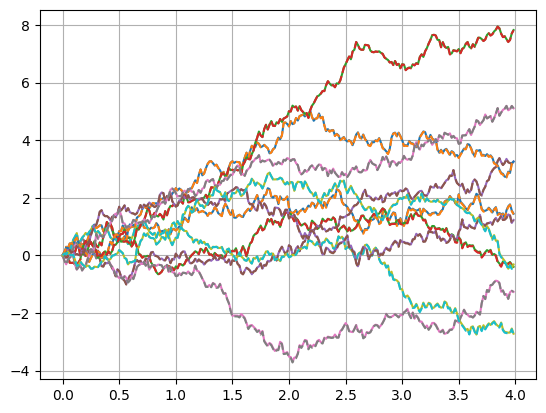

In [73]:
for idx in range(0,meas_voltage.shape[0],1000):
  plt.plot(tvec, meas_voltage[idx,:,0])
  plt.plot(tvec, qutip_volt[idx,:,0],'--')
plt.grid();

In [74]:
meas_voltage.shape

TensorShape([10000, 256, 2])

In [75]:
print(num_traj, tf.reduce_mean(tf.abs(meas_voltage[:,20:,:] - qutip_volt[:num_traj,20:,:])/tf.abs(tf.reduce_mean(qutip_volt[:num_traj,20:,:], axis=0))))
#print(num_traj, tf.reduce_mean(tf.abs(meas_voltage - qutip_volt[:num_traj,:,:])))

10000 tf.Tensor(0.012466949046424761, shape=(), dtype=float64)


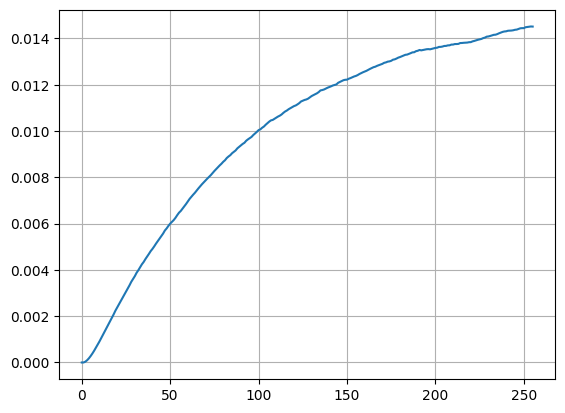

In [76]:
#plt.plot(tf.reduce_mean(tf.abs(meas_voltage[:,20:,:] - qutip_volt[:num_traj,20:,:])/tf.abs(qutip_volt[:num_traj,20:,:]), axis=0)[...,0])
plt.plot(tf.reduce_mean(tf.abs(meas_voltage[:,:,:] - qutip_volt[:num_traj,:,:]), axis=0)[...,0])
plt.grid();

In [77]:
#mint = 0
#maxt = 4.0
#deltat = 2**(-8)
#tvec = np.arange(mint,maxt,deltat)
seq_len = tvec.shape[0]

num_meas = 1
meas_op = [0,1]
num_features = 2
strong_probs = []
input_params = [4]
num_params = len(input_params)

sx, sy, sz = sde_systems.paulis()
rho0 = sde_systems.get_init_rho(sx, sy, 0, 0)

params = np.array([1.395,4.0*2.0*0.83156,0.1469,0.0,0.1], dtype=np.double)

model = flex.build_datagen_model(seq_len, num_features, rho0, num_params, params, deltat, num_traj=1, start_meas=0,
                                 sim_noise=True, comp_iq=True, strong_probs=strong_probs, num_meas=num_meas, meas_op=meas_op,
                                 input_params=input_params)

model.summary()

l46 t =  Tensor("physical_layer/euler_flex_rnn_cell/strided_slice_8:0", shape=(), dtype=float32)
l46 t =  0.0
l46 t =  0.0
l46 t =  Tensor("physical_layer/while/euler_flex_rnn_cell/strided_slice_12:0", shape=(), dtype=float32)
l46 t =  0.0
l46 t =  0.0
Model: "data_gen_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (2,)                         0         ['input_1[0][0]']             
 mbda)                                                                                            
                                                                                                  
 tf.compat.v1.shape_1 (TFOp  (

In [83]:
model_out = model.predict(all_params_traj)

313/313 [==============================] - 45s 143ms/step


In [84]:
model_out.shape

(10000, 256, 2, 3, 1)

In [85]:
num_traj

10000

In [86]:
meas_voltage.shape

TensorShape([10000, 256, 2])

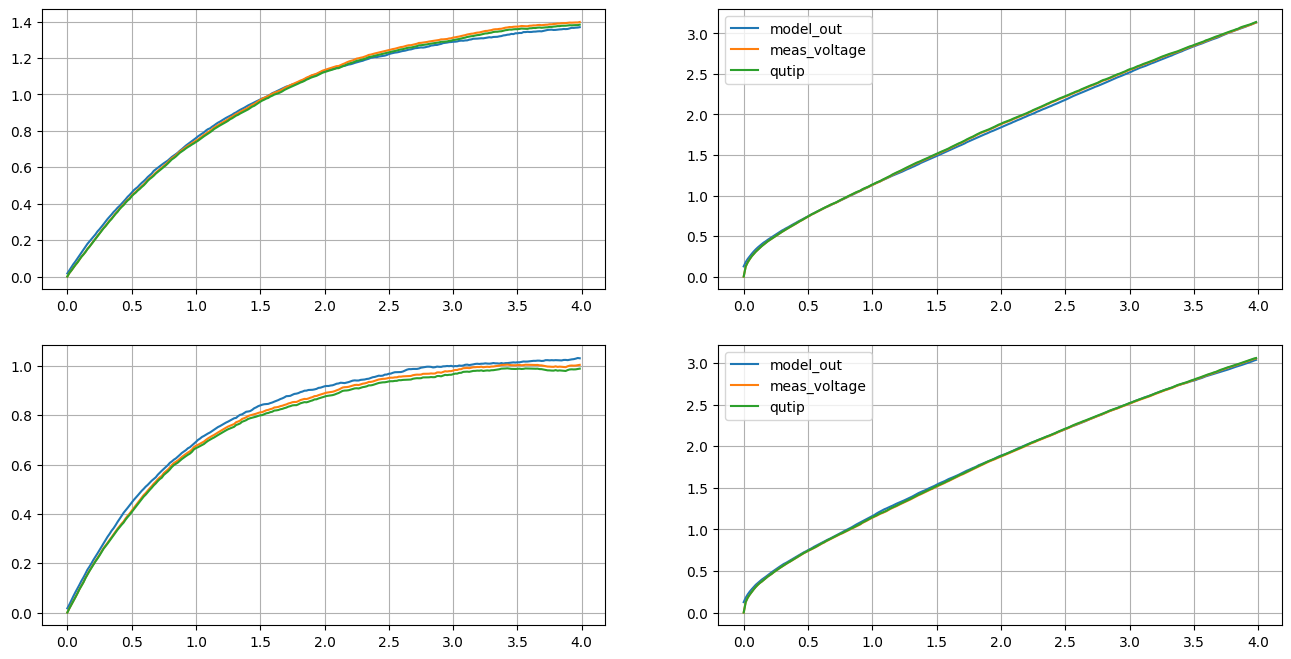

In [87]:
plt.figure(figsize=(16,8))

for qidx in range(2):
  # Plot means
  plt.subplot(2,2,qidx*2 + 1)
  #plt.plot(tvec, tf.reduce_mean(voltage_all[epsidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.reduce_mean(model_out[:,:,qidx,0,0], axis=0))
  plt.plot(tvec, tf.reduce_mean(meas_voltage[:,:,qidx], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:num_traj,:,qidx], axis=0))
  plt.grid()

  # Plot std devs
  plt.subplot(2,2,qidx*2 + 2)
  #plt.plot(tvec, tf.math.reduce_std(voltage_all[epsidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.math.reduce_std(model_out[:,:,qidx,0,0], axis=0), label='model_out')
  plt.plot(tvec, tf.math.reduce_std(meas_voltage[:,:,qidx], axis=0), label='meas_voltage')
  plt.plot(tvec, tf.math.reduce_std(qutip_volt[:num_traj,:,qidx], axis=0), label='qutip')
  plt.legend()
  plt.grid()

# Varying Omega/Epsilon Data

In [88]:
omega = 1.395
kappa = 4.0*0.83156
eta = 0.1469
gamma_s = 0.0
eps = 0.1
params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

In [89]:
mint = 0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)
voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/new_data/xy_xy00_omega_eps/new_data_omega_eps_XY00_kappa0x4_eta0_grp100_N40_T4_dt2em8_xy_avg100_32K/voltage'

voltage = tf.saved_model.load(voltage_dir)

In [90]:
omegas = voltage[:,0,0,0,2,0]
epsilons = voltage[:,0,0,0,3,0]
voltage = voltage[...,0,:]
all_params = tf.concat([omegas[:,tf.newaxis], epsilons[:,tf.newaxis]], axis=1).numpy()

voltage = tf.concat([voltage, 0.0*tf.ones_like(voltage)[...,:1,:], 1.0*tf.ones_like(voltage)[...,:1,:]], axis=3)

In [91]:
# Subsample in time
stride = 4
voltage = voltage[:,:,::stride,...]
#all_probs = all_probs[:,::stride,:]

mint = 0
maxt = 4.0
deltat = 2**(-8)*stride
tvec = np.arange(mint,maxt,deltat)

In [92]:
voltage_orig = voltage
voltage.shape

TensorShape([80, 320, 256, 4, 1])

In [93]:
# Compute the voltage centered differences
#voltage_diff = (voltage[:,:,2:,...] - voltage[:,:,:-2,...])/(2.0*deltat)
voltage_diff = (voltage[:,:,1:,...] - voltage[:,:,:-1,...])/(deltat)
tvec_diff = tvec[1:-1]

In [94]:
voltage_diff.shape

TensorShape([80, 320, 255, 4, 1])

In [95]:
paramidx = 60
omega = all_params[paramidx,0]
eps = all_params[paramidx,1]
print('Omega:', omega)
print('epsilon:', eps)

sx0 = qt.tensor(qt.sigmax(), qt.identity(2))
sx1 = qt.tensor(qt.identity(2), qt.sigmax())
sy0 = qt.tensor(qt.sigmay(), qt.identity(2))
sy1 = qt.tensor(qt.identity(2), qt.sigmay())
sz0 = qt.tensor(qt.sigmaz(), qt.identity(2))
sz1 = qt.tensor(qt.identity(2), qt.sigmaz())
sm0 = qt.tensor(qt.sigmam(), qt.identity(2))
sm1 = qt.tensor(qt.identity(2), qt.sigmam())

sxx = qt.tensor(qt.sigmax(), qt.sigmax())
sxy = qt.tensor(qt.sigmax(), qt.sigmay())
sxz = qt.tensor(qt.sigmax(), qt.sigmaz())

syx = qt.tensor(qt.sigmay(), qt.sigmax())
syy = qt.tensor(qt.sigmay(), qt.sigmay())
syz = qt.tensor(qt.sigmay(), qt.sigmaz())

szx = qt.tensor(qt.sigmaz(), qt.sigmax())
szy = qt.tensor(qt.sigmaz(), qt.sigmay())
szz = qt.tensor(qt.sigmaz(), qt.sigmaz())

H = 0.5*omega*(sx0 + sx1) + eps*szz

xup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + qt.basis(2,1))
yup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + 1j*qt.basis(2,1))
psi0 = qt.tensor(xup, yup)
qtrho0 = psi0*psi0.dag()

Omega: 3.0
epsilon: 1.0


In [110]:
ntraj = 32000
result = qt.smesolve(H, qtrho0, tvec,
                     c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sx0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sy1],
                     sc_ops=[np.sqrt(0.5*eta*kappa) * sx0, np.sqrt(0.5*eta*kappa) * sy1],
                     e_ops=[sx0,sy0,sz0],
                     ntraj=ntraj,
                     dW_factors=[1,1],
                     solver='euler-maruyama',
                     store_measurement=True)

10.0%. Run time:   6.86s. Est. time left: 00:00:01:01
20.0%. Run time:  13.65s. Est. time left: 00:00:00:54
30.0%. Run time:  20.53s. Est. time left: 00:00:00:47
40.0%. Run time:  27.32s. Est. time left: 00:00:00:40
50.0%. Run time:  34.44s. Est. time left: 00:00:00:34
60.0%. Run time:  41.27s. Est. time left: 00:00:00:27
70.0%. Run time:  48.00s. Est. time left: 00:00:00:20
80.0%. Run time:  54.79s. Est. time left: 00:00:00:13
90.0%. Run time:  61.56s. Est. time left: 00:00:00:06
Total run time:  68.35s


In [111]:
all_meas = np.zeros([len(result.measurement), result.measurement[0].shape[0], result.measurement[0].shape[1]], result.measurement[0].dtype)
for idx in range(len(result.measurement)):
  all_meas[idx,:,:] = result.measurement[idx]
all_meas.shape

(32000, 256, 2)

In [112]:
print(tf.math.reduce_std(tf.reduce_mean(all_meas[200:300,:,0], axis=0)))
tf.math.reduce_std(voltage_diff[paramidx,4,:,0,0])

tf.Tensor(0.8012023259291559, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=0.8693520325936526>

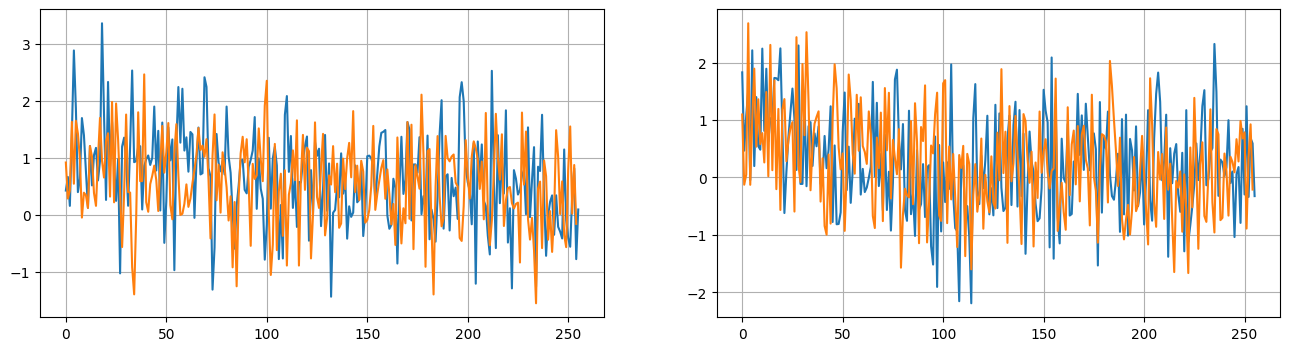

In [113]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tf.reduce_mean(all_meas[200:300,:,qidx], axis=0))
  plt.plot(voltage_diff[paramidx,1,:,qidx,0])
  #plt.plot(tf.math.reduce_std(all_meas[:,:,0], axis=0))
  #plt.plot(all_meas[0,:,0])
  #plt.plot(result.expect[0])
  #plt.plot(all_exp[:,4])
  plt.grid()

In [114]:
all_meas.shape

(32000, 256, 2)

In [115]:
qutip_diff = tf.reshape(all_meas, [-1,100,all_meas.shape[1], all_meas.shape[2]])
qutip_diff = tf.reduce_mean(qutip_diff, axis=1)
qutip_diff.shape

TensorShape([320, 256, 2])

In [116]:
#for ii in range(35):
#  print(tf.math.reduce_std(qutip_diff[ii,:,0]).numpy(), tf.math.reduce_std(voltage_diff[epsidx,ii,:,0,0]).numpy())
print(tf.reduce_mean(tf.math.reduce_std(qutip_diff[:,:,0], axis=1)).numpy(), tf.reduce_mean(tf.math.reduce_std(voltage_diff[paramidx,:,:,0,0], axis=1)).numpy())
print(tf.reduce_mean(tf.math.reduce_std(qutip_diff[:,:,1], axis=1)).numpy(), tf.reduce_mean(tf.math.reduce_std(voltage_diff[paramidx,:,:,1,0], axis=1)).numpy())

0.8220719637037636 0.8225016313062895
0.8457920096488852 0.8436270158694334


In [117]:
def diff_to_volt(diff, deltat):
  volt = np.zeros_like(diff.numpy())
  for tidx in range(diff.shape[-2]):
    if tidx < diff.shape[-2] - 1:
      volt[...,tidx+1,:] = volt[...,tidx,:] + deltat*diff[...,tidx,:]
    else:
      volt = np.concatenate([volt, volt[...,tidx:tidx+1,:] + deltat*diff[...,tidx:tidx+1,:]], axis=-2)
  return volt

In [118]:
volt = diff_to_volt(voltage_diff[...,0], deltat)
qutip_volt = diff_to_volt(qutip_diff, deltat)[:,:-1,:]

In [119]:
print(volt.shape)
print(qutip_volt.shape)

(80, 320, 256, 4)
(320, 256, 2)


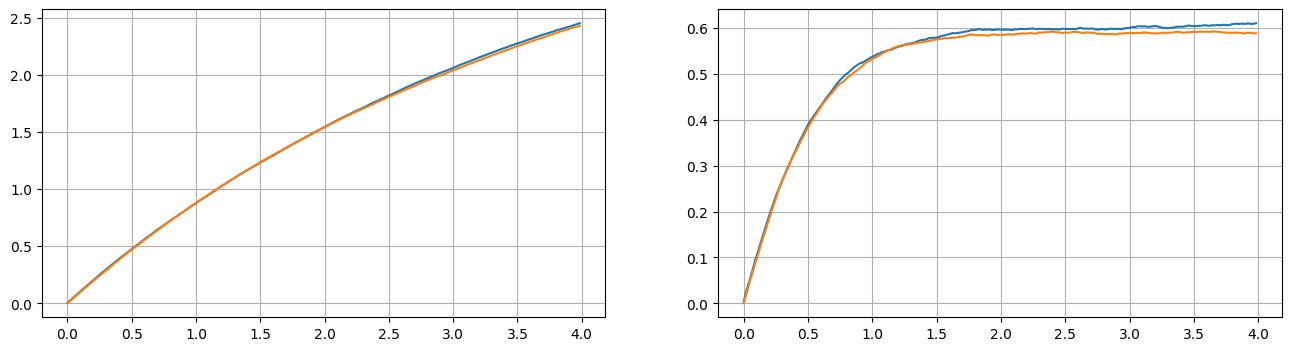

In [120]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tvec, tf.reduce_mean(voltage[paramidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

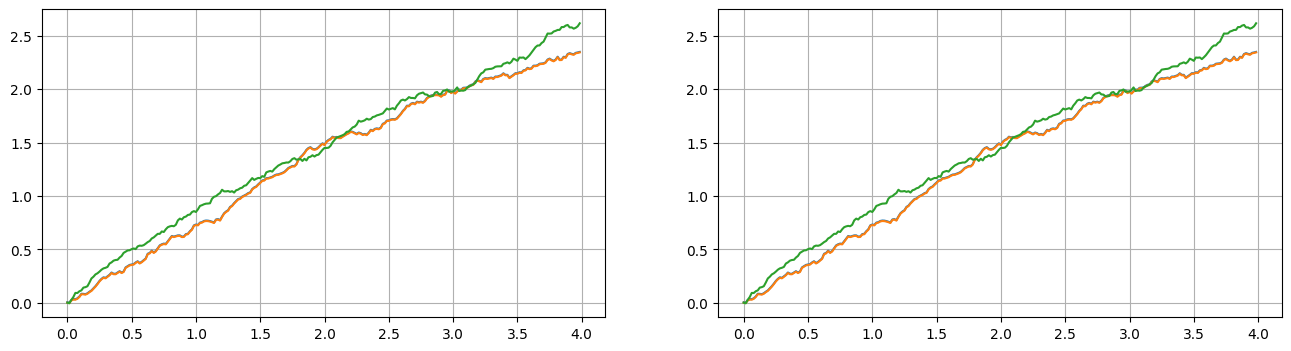

In [121]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tvec, voltage[paramidx,0,:,0,0])
  plt.plot(tvec, volt[paramidx,0,:,0])
  plt.plot(tvec, qutip_volt[0,:,0])
  plt.grid()

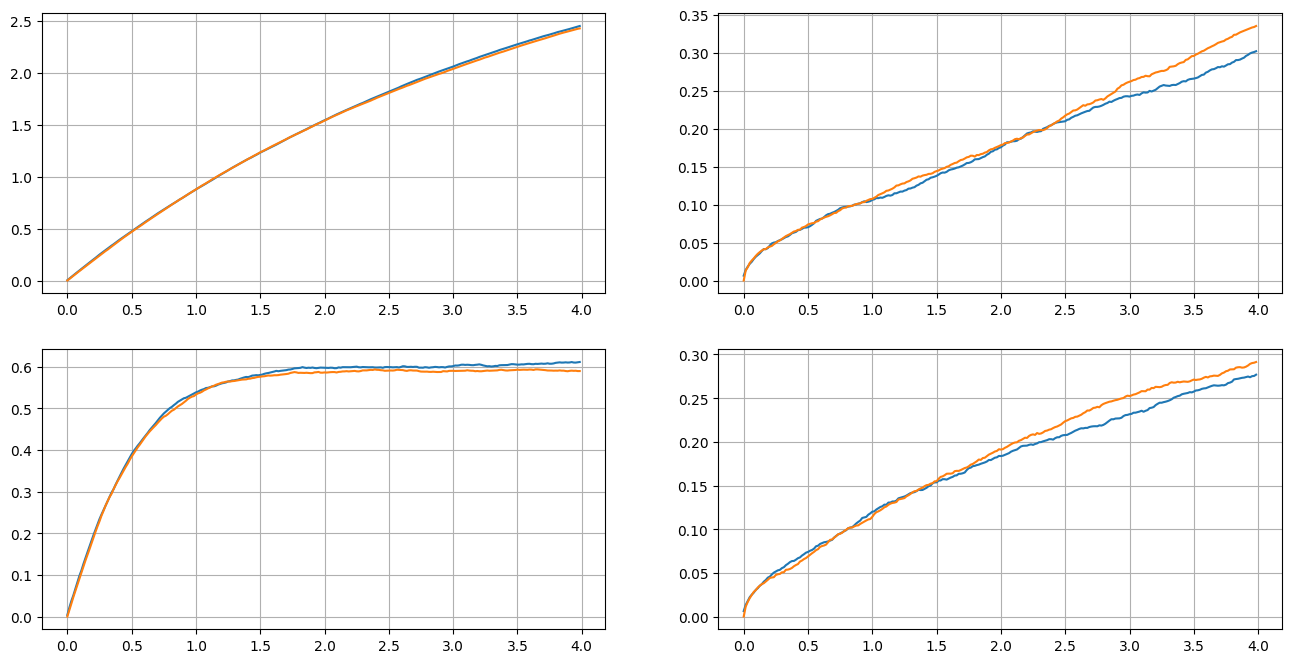

In [122]:
plt.figure(figsize=(16,8))

for qidx in range(2):
  # Plot means
  plt.subplot(2,2,qidx*2 + 1)
  plt.plot(tvec, tf.reduce_mean(voltage[paramidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

  # Plot std devs
  plt.subplot(2,2,qidx*2 + 2)
  plt.plot(tvec, tf.math.reduce_std(voltage[paramidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.math.reduce_std(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

In [123]:
import datetime
print(datetime.datetime.now())

2024-10-15 00:55:09.940751
